In [1]:
import uuid
import pandas as pd
import json
import os
import glob
import jsonlines
import requests
from tqdm import trange
import random
import json_repair
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from collections import Counter

In [6]:
# get formate sky size
def get_sky_size(max_context_length, n):
    intervel = int(max_context_length / n)
    return [i for i in range(intervel, max_context_length + 1, intervel)]

# reduce duplicate from the predicted results
def reduce_duplicate(predicted, m):
    if len(predicted) > m:
        predicted = predicted[:m]
        predicted = list(set(predicted))
    else:
        predicted = list(set(predicted))
    return predicted

# get results from English version of the Counting-Stars
def get_data_EN(folder_path, max_context_length, m, n):
    sky_size = get_sky_size(max_context_length, n)
    data = []
    average_score = 0
    indicator = 0
    for item in jsonlines.Reader(folder_path):
        if "```" in item['answer']:
            predicted = json_repair.loads(item['answer'].replace('```','').replace("json",'').strip())['little_penguin']
        else:
            predicted = json_repair.loads(item['answer'])['little_penguin']    
        predicted = reduce_duplicate(predicted, m)
        for i in range(1, m+1):          
            counting_times = i
            try:
                if predicted[i-1] in item["reference_counting_results"]:
                    score = 1
                else:
                    score = 0
            except:
                score = 0
            average_score += score
            data.append({
                "Counting Times": counting_times,
                "Sky Size": item['sky_size'],
                "Score": score
                })
    df = pd.DataFrame(data)
    print (df.head())
    print (f"You have {len(df)} rows")
    pivot_table = pd.pivot_table(df, values='Score', index=['Counting Times', 'Sky Size'], aggfunc='mean').reset_index()
    pivot_table = pivot_table.pivot(index="Counting Times", columns="Sky Size", values="Score")
    return pivot_table, pivot_table.mean(axis=None).round(3)

# get results from Chinese version of the Counting-Stars
def get_data_ZH(folder_path, max_context_length, m, n):
    sky_size = get_sky_size(max_context_length, n)
    data = []
    average_score = 0
    indicator = 0
    for item in jsonlines.Reader(folder_path):
        if "```" in item['answer']:
            predicted = json_repair.loads(item['answer'].replace('```','').replace("json",'').strip())['小企鹅']
        else:
            predicted = json_repair.loads(item['answer'])['小企鹅']    
        predicted = reduce_duplicate(predicted, m)
        for i in range(1, m+1):          
            counting_times = i
            try:
                if predicted[i-1] in item["reference_counting_results"]:
                    score = 1
                else:
                    score = 0
            except:
                score = 0
            average_score += score
            data.append({
                "Counting Times": counting_times,
                "Sky Size": int(item['sky_size'] / 0.725),
                "Score": score
                })
    df = pd.DataFrame(data)
    print (df.head())
    print (f"You have {len(df)} rows")
    pivot_table = pd.pivot_table(df, values='Score', index=['Counting Times', 'Sky Size'], aggfunc='mean').reset_index()
    pivot_table = pivot_table.pivot(index="Counting Times", columns="Sky Size", values="Score")
    return pivot_table, pivot_table.mean(axis=None).round(3)

In [7]:
m = 32
n = 32
max_context_length = 128000
context_story = "stone"
folder_path_gpt4 = open(f"../results/{context_story}_gpt4_{m}_{n}.txt","r")
folder_path_kimi = open(f"../results/{context_story}_kimi_{m}_{n}.txt","r")
viz_data_gpt4, mean_gpt4 = get_data_ZH(folder_path_gpt4, max_context_length, m, n)
viz_data_kimi, mean_kimi = get_data_ZH(folder_path_kimi, max_context_length, m, n)

   Counting Times  Sky Size  Score
0               1    4000.0      1
1               2    4000.0      1
2               3    4000.0      1
3               4    4000.0      1
4               5    4000.0      1
You have 1024 rows
   Counting Times  Sky Size  Score
0               1    4000.0      1
1               2    4000.0      1
2               3    4000.0      1
3               4    4000.0      1
4               5    4000.0      1
You have 1024 rows


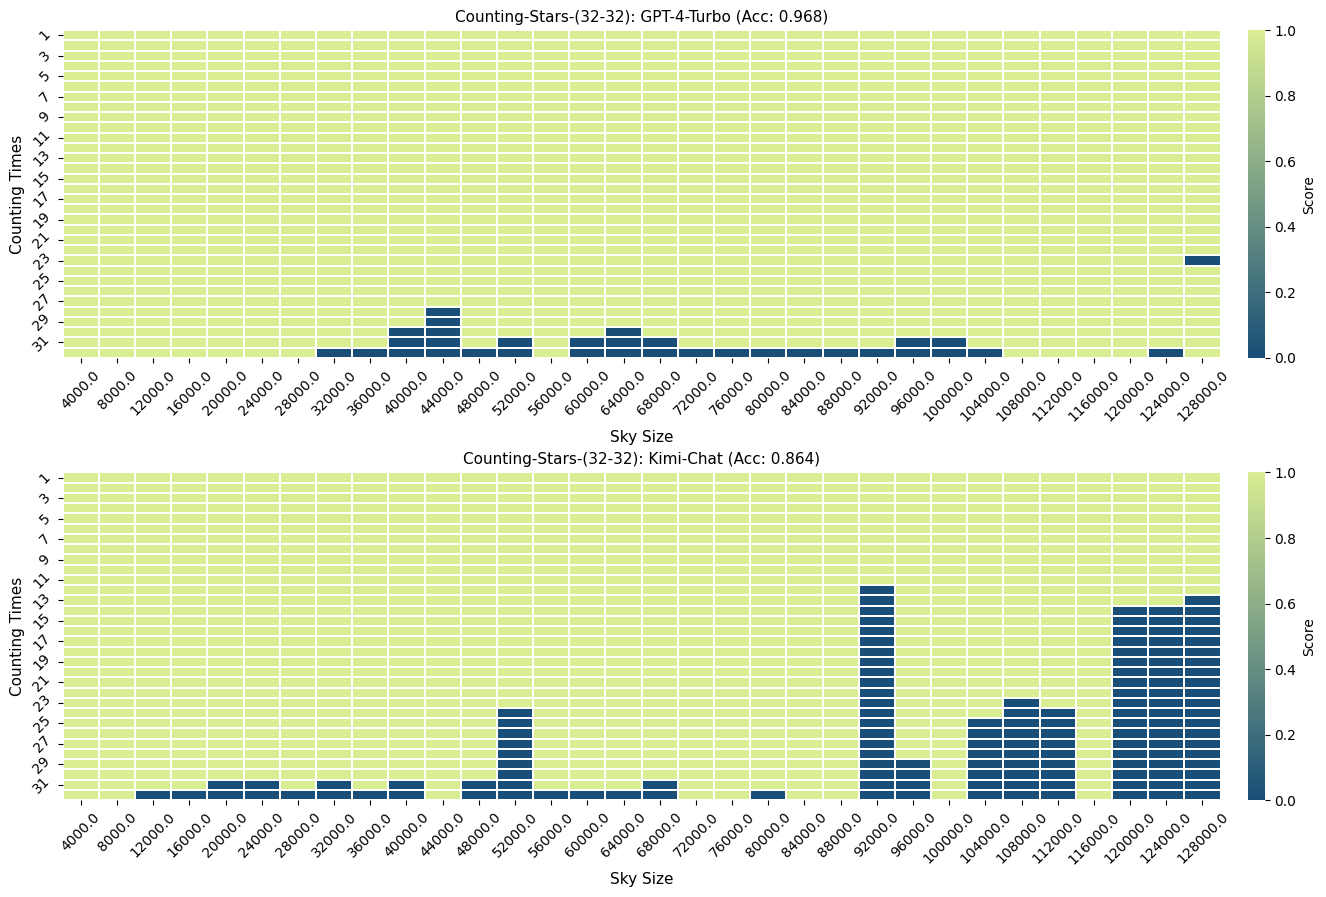

In [8]:
# Create a custom colormap. Go to https://coolors.co/ and pick cool colors
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#184E77", "#D9ED92"])

fig = plt.figure(figsize=(18, 10))

ax1 = fig.add_subplot(2, 1, 1)
# Create the heatmap with better aesthetics
sns.heatmap(
    viz_data_gpt4,
    #annot=True,
    fmt="g",
    cmap=cmap,
    linewidths=0.3,
    cbar_kws={'label': 'Score', "pad": 0.02}
)
#[0.5,1.5,2.5]
#labels = [i for i in range(2, 34, 2)]
#x = [i-0.5 for i in range(2, 34, 2)]

# More aesthetics
plt.title(f'Counting-Stars-({m}-{n}): GPT-4-Turbo (Acc: {mean_gpt4})', size=11)  # Adds a title
plt.xlabel('Sky Size', size=11)  # X-axis label
plt.ylabel('Counting Times', size=11)  # Y-axis label
plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
plt.yticks(rotation=45)  # Ensures the y-axis labels are horizontal

ax1 = fig.add_subplot(2, 1, 2)
# Create the heatmap with better aesthetics
sns.heatmap(
    viz_data_kimi,
    #annot=True,
    fmt="g",
    cmap=cmap,
    linewidths=0.3,
    cbar_kws={'label': 'Score', "pad": 0.02}
)
#[0.5,1.5,2.5]
#labels = [i for i in range(2, 34, 2)]
#x = [i-0.5 for i in range(2, 34, 2)]

# More aesthetics
plt.title(f'Counting-Stars-({m}-{n}): Kimi-Chat (Acc: {mean_kimi})', size=11)  # Adds a title
plt.xlabel('Sky Size', size=11)  # X-axis label
plt.ylabel('Counting Times', size=11)  # Y-axis label
plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
plt.yticks(rotation=45)  # Ensures the y-axis labels are horizontal


fig.subplots_adjust(hspace=0.35)
plt.savefig(f"{context_story}_gpt4_kimi_{m}_{n}.pdf", dpi=180, bbox_inches='tight')
plt.show()